<h2>BUSINESS PROBLEM</h2>
<p>The main objective of this project is to determine the best possible location for opening an Mexican Restaurant in my hometown Vadodara,India.</p>
<p>The location will be determined based on the different araes of the city(Vadodara), already present Mexican restaurant in varios geographical location of city and ease of accessibility by maximum number of people so that the revenue from the latest venture can be maximized.</p>

In [59]:
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim
import geocoder

import requests
from bs4 import BeautifulSoup


import folium
    
from sklearn.cluster import KMeans

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt


In [6]:
g = geocoder.arcgis('Vadodara, India')
vd_lat = g.latlng[0]
vd_lng = g.latlng[1]
print("The Latitude and Longitude of Vadodara is {} and {}".format(vd_lat, vd_lng))

The Latitude and Longitude of Vadodara is 22.30946000000006 and 73.17988000000008


In [17]:
neig = requests.get("https://en.wikipedia.org/wiki/Category:Urban_and_suburban_areas_of_Vadodara").text
soup = BeautifulSoup(neig, 'html.parser')

In [18]:
neighborhoodlist = []

In [19]:
for i in soup.find_all('div', class_='mw-category')[0].find_all('a'):
    neighborhoodlist.append(i.text)

#Creating a dataframe from the list
neig_df = pd.DataFrame({"Locality": neighborhoodlist})
neig_df.head()

,Locality
0,Akota
1,Alkapuri
2,Fatehgunj
3,Karelibaug
4,Kayavarohan


In [20]:
neig_df.shape

(14, 1)

In [22]:
def get_location(localities):
    g = geocoder.arcgis('{}, Vadodara, India'.format(localities))
    get_latlng = g.latlng
    return get_latlng

In [23]:
co_ordinates = []
#Getting the co-ordinates of each locality using the function defined above
for i in neig_df["Locality"].tolist():
    co_ordinates.append(get_location(i))
print(co_ordinates)

[[22.29128000000003, 73.16947000000005], [22.314190000000053, 73.17424000000005], [22.325480000000027, 73.18949000000003], [22.325710000000072, 73.20177000000007], [22.074140000000057, 73.25027000000006], [22.27547000000004, 73.19164000000006], [22.312340000000063, 73.16282000000007], [22.30394000000007, 73.19981000000007], [22.41571382152998, 73.12296486684846], [22.312860000000057, 73.18762000000004], [22.32367000000005, 73.16472000000005], [22.284800000000075, 73.14599000000004], [22.312620000000038, 73.38860000000005], [22.30946000000006, 73.17988000000008]]


In [24]:
co_ordinates[:5]

[[22.29128000000003, 73.16947000000005],
 [22.314190000000053, 73.17424000000005],
 [22.325480000000027, 73.18949000000003],
 [22.325710000000072, 73.20177000000007],
 [22.074140000000057, 73.25027000000006]]

In [25]:
co_ordinates_df = pd.DataFrame(co_ordinates, columns=['Latitudes', 'Longitudes'])

In [26]:
neig_df["Latitudes"] = co_ordinates_df["Latitudes"]
neig_df["Longitudes"] = co_ordinates_df["Longitudes"]

In [27]:
print("The shape of neig_df is {}".format(neig_df.shape))
neig_df.head()

The shape of neig_df is (14, 3)


,Locality,Latitudes,Longitudes
0,Akota,22.29128,73.16947
1,Alkapuri,22.31419,73.17424
2,Fatehgunj,22.32548,73.18949
3,Karelibaug,22.32571,73.20177
4,Kayavarohan,22.07414,73.25027


In [37]:
vd_map = folium.Map(location=[vd_lat, vd_lng],zoom_start=13)

#adding markers to the map for localities
#marker for Vadodara
folium.Marker([vd_lat, vd_lng], popup='<i>Vadodara</i>', color='red', tooltip="Click to see").add_to(vd_map)

#markers for localities
for latitude,longitude,name in zip(neig_df["Latitudes"], neig_df["Longitudes"], neig_df["Locality"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        color='blue',
        popup=name,
        fill=True,
        fill_color='#3186ff'
    ).add_to(vd_map)

vd_map

In [38]:
CLIENT_ID = 'KIZDKDCBBKDFNEYQB3GQLG54TUPDWZVZH1ZNFZVZPVKRYC4I' # your Foursquare ID
CLIENT_SECRET = '1UHDHPEEYLYDOL0BO5F3XHVIYOCB43KSN24XFFJ5TVFIUJNC' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100

In [39]:
radius = 2000
LIMIT = 100

venues = []

for lat, lng, locality in zip(neig_df["Latitudes"], neig_df["Longitudes"], neig_df["Locality"]):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']

    for venue in results:
        venues.append((locality, lat, lng, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']['location']['lng'], venue['venue']['categories'][0]['name'], venue['venue']['id']))

In [40]:
venues[0]

('Akota',
 22.29128000000003,
 73.16947000000005,
 'Dairy Den',
 22.29609946908187,
 73.16379729331499,
 'Ice Cream Shop',
 '4fad14c1e4b03481b5326ef3')

In [41]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Locality', 'Latitude', 'Longitude', 'Venue name', 'Venue Lat', 'Venue Lng', 'Venue Category', 'Venue ID']
venues_df.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID
0,Akota,22.29128,73.16947,Dairy Den,22.296099,73.163797,Ice Cream Shop,4fad14c1e4b03481b5326ef3
1,Akota,22.29128,73.16947,Pizza on the Rock,22.298322,73.164806,Pizza Place,4f539666e4b0ac6d0d48343c
2,Akota,22.29128,73.16947,McDonald's,22.297058,73.164798,Fast Food Restaurant,4d5a7cb51d4a8cfaf4b598ed
3,Akota,22.29128,73.16947,Kai Asia,22.293349,73.174587,Asian Restaurant,4d0e21b2eea9b60c5825623f
4,Akota,22.29128,73.16947,Havmor Restaurant,22.301754,73.165713,Indian Restaurant,4fabc783e4b08e1c182108b3


In [42]:
venues_df.shape

(494, 8)

In [49]:
res_df = pd.DataFrame({'Venue Category': venues_df['Venue Category'], 'Strength': venues_df['Venue Category']})
res_df = res_df.groupby(['Venue Category']).count()
res_df = res_df.sort_values(['Strength'], ascending=False)
print(res_df.head())
print("We can see that most restaurants belongs to Indian Restaurant category i.e. {}".format(res_df['Strength'][0]))

                      Strength
Venue Category                
Indian Restaurant           77
Café                        57
Fast Food Restaurant        39
Shopping Mall               26
Multiplex                   26
We can see that most restaurants belongs to Indian Restaurant category i.e. 77


In [48]:
res_df.shape

(60, 1)

In [50]:
demo1_df = pd.DataFrame({'Venue Category':res_df.index[:50]})
category_strength=[]
for i in range(50):
    category_strength.append(res_df['Strength'][i])
demo2_df = pd.DataFrame(category_strength, columns=['Strength'])
demo_df = pd.DataFrame({'Venue Category': demo1_df['Venue Category'], 'Strength': demo2_df['Strength']})
demo_df.head()

,Venue Category,Strength
0,Indian Restaurant,77
1,Café,57
2,Fast Food Restaurant,39
3,Shopping Mall,26
4,Multiplex,26


In [51]:
word_string = ''
for i in range(50):
    tmp = demo_df['Venue Category'][i]
    if len(tmp.split(' ')) == 1:
        word_string = word_string + (tmp + ' ')*demo_df['Strength'][i]
    else:
        part = tmp.split(' ')
        tmp = part[0]+'_'+part[1]
        word_string = word_string + (tmp + ' ')*demo_df['Strength'][i]

Word cloud created!


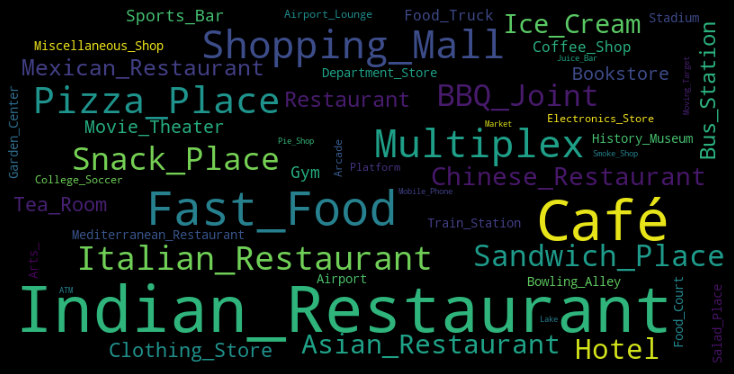

In [60]:
wordcloud = WordCloud(width=800, height=400, collocations=False).generate(word_string)
print('Word cloud created!')
# Open a plot of the generated image.

plt.figure( figsize=(10,9), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [61]:
cat_res_list = res_df.index[0:50]
cat_res_list

Index(['Indian Restaurant', 'Café', 'Fast Food Restaurant', 'Shopping Mall',
       'Multiplex', 'Pizza Place', 'Italian Restaurant', 'Snack Place',
       'BBQ Joint', 'Sandwich Place', 'Hotel', 'Asian Restaurant',
       'Ice Cream Shop', 'Chinese Restaurant', 'Mexican Restaurant',
       'Restaurant', 'Bus Station', 'Tea Room', 'Clothing Store',
       'Movie Theater', 'Bookstore', 'Sports Bar', 'Gym', 'Coffee Shop',
       'Food Truck', 'History Museum', 'Miscellaneous Shop',
       'Mediterranean Restaurant', 'Arts & Crafts Store', 'Stadium',
       'Bowling Alley', 'Train Station', 'Airport', 'Salad Place',
       'Garden Center', 'Food Court', 'Department Store', 'Electronics Store',
       'Platform', 'College Soccer Field', 'Arcade', 'Airport Lounge',
       'Pie Shop', 'Moving Target', 'Smoke Shop', 'ATM', 'Mobile Phone Shop',
       'Market', 'Lake', 'Juice Bar'],
      dtype='object', name='Venue Category')

In [66]:
venue_etables = venues_df[venues_df['Venue Category'].isin(['Indian Restaurant', 'Café', 'Fast Food Restaurant', 'Shopping Mall',
       'Multiplex', 'Pizza Place', 'Italian Restaurant', 'Snack Place',
       'BBQ Joint', 'Sandwich Place', 'Hotel', 'Asian Restaurant',
       'Ice Cream Shop', 'Chinese Restaurant', 'Mexican Restaurant',
       'Restaurant', 'Bus Station', 'Tea Room', 'Clothing Store',
       'Movie Theater', 'Bookstore', 'Sports Bar', 'Gym', 'Coffee Shop',
       'Food Truck', 'History Museum', 'Miscellaneous Shop',
       'Mediterranean Restaurant', 'Arts & Crafts Store', 'Stadium',
       'Bowling Alley', 'Train Station', 'Airport', 'Salad Place',
       'Garden Center', 'Food Court', 'Department Store', 'Electronics Store',
       'Platform', 'College Soccer Field', 'Arcade', 'Airport Lounge',
       'Pie Shop', 'Moving Target', 'Smoke Shop', 'ATM', 'Mobile Phone Shop',
       'Market', 'Lake', 'Juice Bar'])]

In [71]:
vd_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

vd_onehot['Locality'] = venues_df['Locality']

#moving the locality column to the front
vd_onehot = vd_onehot[ [ 'Locality' ] + [ col for col in vd_onehot.columns if col!='Locality' ] ]
vd_onehot.head()

,Locality,ATM,Airport,Airport Lounge,Airport Service,Arcade,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,...,Restaurant,Salad Place,Sandwich Place,Shopping Mall,Smoke Shop,Snack Place,Sports Bar,Stadium,Tea Room,Train Station
0,Akota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Akota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Akota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Akota,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Akota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
vd_grouped = vd_onehot.groupby(['Locality']).mean().reset_index()
print(vd_grouped.shape)
vd_grouped.head()

(12, 61)


,Locality,ATM,Airport,Airport Lounge,Airport Service,Arcade,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,...,Restaurant,Salad Place,Sandwich Place,Shopping Mall,Smoke Shop,Snack Place,Sports Bar,Stadium,Tea Room,Train Station
0,Akota,0.0,0.000000,0.0000,0.00000,0.000000,0.000000,0.060606,0.0,0.000000,...,0.000000,0.000000,0.060606,0.030303,0.00000,0.030303,0.030303,0.000000,0.030303,0.000000
1,Alkapuri,0.0,0.000000,0.0000,0.00000,0.000000,0.010989,0.021978,0.0,0.032967,...,0.021978,0.010989,0.032967,0.054945,0.00000,0.032967,0.010989,0.010989,0.010989,0.000000
2,Fatehgunj,0.0,0.026316,0.0000,0.00000,0.026316,0.000000,0.026316,0.0,0.000000,...,0.000000,0.000000,0.026316,0.052632,0.00000,0.052632,0.000000,0.000000,0.000000,0.026316
3,Karelibaug,0.0,0.062500,0.0625,0.03125,0.031250,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.062500,0.031250,0.03125,0.031250,0.000000,0.000000,0.000000,0.000000
4,Manjalpur,0.0,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.090909,0.00000,0.000000,0.000000,0.000000,0.090909,0.090909


In [77]:
len(vd_grouped[vd_grouped['Mexican Restaurant'] > 0])

7

In [78]:
vd_mexican = vd_grouped[['Locality', 'Mexican Restaurant']]
vd_mexican.head()

,Locality,Mexican Restaurant
0,Akota,0.000000
1,Alkapuri,0.021978
2,Fatehgunj,0.026316
3,Karelibaug,0.031250
4,Manjalpur,0.000000


In [81]:
vd_map = folium.Map(location=[vd_lat, vd_lng],zoom_start=11)

#adding markers to the map for localities
#marker for Vadodara
folium.Marker([vd_lat, vd_lng], popup='<i>Vadodara</i>', color='red', tooltip="Click to see").add_to(vd_map)

#markers for localities
for latitude,longitude,name,strength in zip(neig_df["Latitudes"], neig_df["Longitudes"], neig_df["Locality"], vd_mexican["Mexican Restaurant"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius=strength*300,
        color='magenta',
        popup=name,
        fill=True,
        fill_color='#3186ff'
    ).add_to(vd_map)

vd_map

In [83]:
cluster = 4

#Dataframe for clustering
vd_clustering = vd_mexican.drop(['Locality'], 1)

#run K-means clustering
k_means = KMeans(init="k-means++", n_clusters=cluster, n_init=12).fit(vd_clustering)

#getting the labels for first 10 locality 
print(k_means.labels_[0:10])

[0 1 3 3 0 2 0 2 2 0]


In [84]:
vd_labels = vd_mexican.copy()


vd_labels["Cluster Label"] = k_means.labels_

vd_labels.head()

,Locality,Mexican Restaurant,Cluster Label
0,Akota,0.000000,0
1,Alkapuri,0.021978,1
2,Fatehgunj,0.026316,3
3,Karelibaug,0.031250,3
4,Manjalpur,0.000000,0


In [85]:
vd_labels = vd_labels.join(neig_df.set_index('Locality'), on='Locality')
vd_labels.head()

,Locality,Mexican Restaurant,Cluster Label,Latitudes,Longitudes
0,Akota,0.000000,0,22.29128,73.16947
1,Alkapuri,0.021978,1,22.31419,73.17424
2,Fatehgunj,0.026316,3,22.32548,73.18949
3,Karelibaug,0.031250,3,22.32571,73.20177
4,Manjalpur,0.000000,0,22.27547,73.19164


In [86]:
vd_labels.sort_values(["Cluster Label"], inplace=True)
vd_labels.head()

,Locality,Mexican Restaurant,Cluster Label,Latitudes,Longitudes
0,Akota,0.0,0,22.29128,73.16947
4,Manjalpur,0.0,0,22.27547,73.19164
6,Raopura,0.0,0,22.30394,73.19981
9,Tandalja,0.0,0,22.28480,73.14599
11,Vaghodia INA,0.0,0,22.31262,73.38860


In [87]:
vd_only_labels = vd_labels.drop(columns=['Mexican Restaurant','Latitudes','Longitudes'])
vd_only_labels.head()

,Locality,Cluster Label
0,Akota,0
4,Manjalpur,0
6,Raopura,0
9,Tandalja,0
11,Vaghodia INA,0


In [91]:
cluster_map = folium.Map(location=[vd_lat, vd_lng],zoom_start=11)

#marker for Bangalore
folium.Marker([vd_lat, vd_lng], popup='<i>Vadodara</i>', color='red', tooltip="Click to see").add_to(cluster_map)

#Getting the colors for the clusters
col = ['red', 'green', 'blue']

#markers for localities
for latitude,longitude,name,clus in zip(vd_labels["Latitudes"], vd_labels["Longitudes"], vd_labels["Locality"], vd_labels["Cluster Label"]):
    label = folium.Popup(name + ' - Cluster ' + str(clus+1))
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        color=col[clus-1],
        popup=label,
        fill=False,
        fill_color=col[clus-1],
        fill_opacity=0.3
    ).add_to(cluster_map)
       
cluster_map

<h3>So,from above clustering map we can analyse which is the best location for opening an Mexican Restaurant in Vadodara,India.</h3>